# Confidence Intervals and Bootstrap


I use the bootstrap method in order to analyze and make predictions on the performance of prospective hockey players from a data set of draftees and their respective athletic stats from 2005. I am particularly interested in modelling the relationship between the age and weight of a draftee and their overall performance scores. I also write my own function for computing a 95% confidence interval for a given data set.

In [1]:
#import the relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
import sklearn.linear_model
from scipy.stats import t

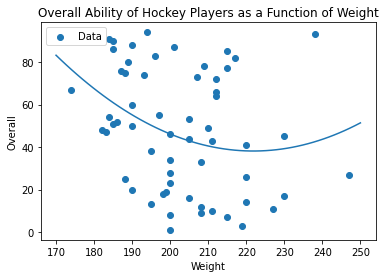

Training rsquared is  -0.8590603025266965


In [3]:
#load in the data and fit a quick linear model to the weights of players as a function of height using a quadratic regression
df= pd.read_csv("hockey_draftees_2005.csv")

# Create and fit the model 
X=df.wt.values
y=df.overall.values
X=np.c_[X, X**2]
model = sklearn.linear_model.LinearRegression()
model.fit(X,y)

# Make the scatter plot 
plt.scatter(df.wt, df.overall, label="Data")
plt.xlabel("Weight")
plt.ylabel("Overall")
plt.title("Overall Ability of Hockey Players as a Function of Weight")
plt.legend()


#Generate and plot the predicted values
weights=np.linspace(170,250, len(X))
Xtest=np.c_[weights, weights**2]
ypred=model.predict(Xtest)
plt.plot(weights,ypred,label="Predicted Values")
plt.show()


# Calculate residuals (R2) and print them 
residuals=np.subtract(ypred, y)
RSS=np.sum(np.square(residuals))
TSS=np.sum(np.square(np.subtract(np.mean(df.overall), df.overall)))
rsquared=1-(RSS/TSS)

print('Training rsquared is ', rsquared)

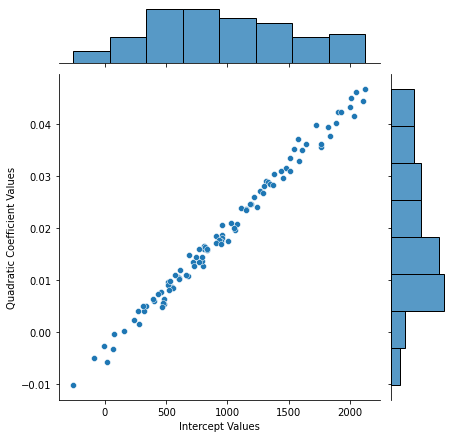

In [6]:
#now use the bootstrap method to create a confidence interval on the linear and quadratic model coefficients
# Write a Bootstrap function that records the fitted models 
def BootstrapCoef(data, numboot):
    # Write the function here
    n=len(data)
    theta=np.zeros((numboot,3))
    for i in range(numboot):
        d=data.sample(n, replace=True)
        X_boot=np.c_[d.wt,d.wt**2]
        model.fit(X_boot,d.overall)
        theta[i,0]=model.intercept_
        theta[i,1:3]=model.coef_
    return theta

# Run the function over your data
thetaBS=BootstrapCoef(df,100)
thetaBS

# Make the scatterplot
axis=sns.jointplot(x=thetaBS[:,0], y=thetaBS[:,2])
axis.set_axis_labels('Intercept Values', 'Quadratic Coefficient Values')
# plt.title("Quadratic Coefficient as a Function of Intercept Value")
plt.show()

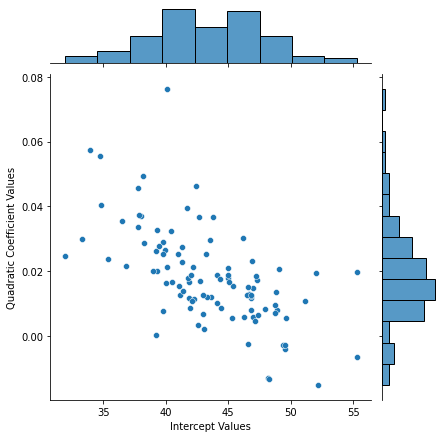

In [7]:
#explore the effect on the relationship above when the mean weight is subtracted from each weight value in a copy data set
# Subtract the mean weight from the weight column here
dfCopy=df
meanWeight=np.mean(dfCopy.wt)
dfCopy.wt=np.subtract(dfCopy.wt,meanWeight)

# Re-run the bootstrap algorithm over the new data here
thetaBS2=BootstrapCoef(dfCopy,100)

# Plot the new result here:
axis=sns.jointplot(x=thetaBS2[:,0], y=thetaBS2[:,2])
axis.set_axis_labels('Intercept Values', 'Quadratic Coefficient Values')
plt.show()

Observation: The two graphs look so different because the intercept and the quadratic coeffcients are closley related, and when we change what the values of the intercept will be in the model (this is a consequence of subtracting the mean from the weight column values), the quadratic coefficients must also change in order to account for this. The large difference in the correlations between the two parameters in each of the plots is caused by the difference between the data used to make predictions in the first model (the training data) and the data used to make predictions in the second model (the mean-subtracted data). What is common in the two cases is that the marginal distribution of the quadratic coefficient is the same.

[-0.00999525  0.05258546]
My confidence interval is between -0.03422123736119553  and  0.028359473057441426 .


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


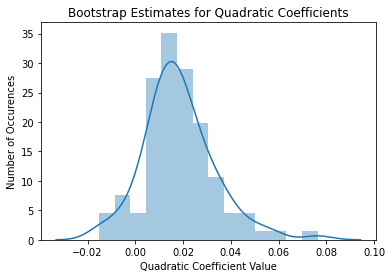

In [9]:
#now lets take a look at the bootstrap estimates for the quadratic coefficient and compute a 95% confidence interval
# Plot histogram 
plot=sns.distplot(thetaBS2[:,2])
plot.set_xlabel("Quadratic Coefficient Value")
plot.set_ylabel("Number of Occurences")
plt.title("Bootstrap Estimates for Quadratic Coefficients")
# Calculate bootstrap interval
boot_quant=np.quantile(thetaBS2[:,2],[0.025,0.975])
print(boot_quant)
boot_ci=[np.mean(thetaBS2[:,2])-boot_quant[1], np.mean(thetaBS2[:,2])-boot_quant[0]]

print('My confidence interval is between', boot_ci[0], ' and ', boot_ci[1],".")

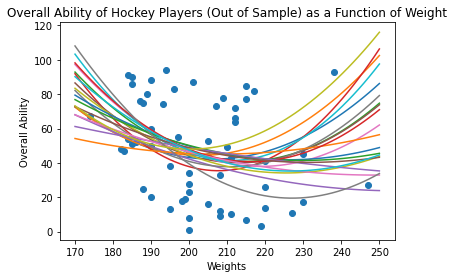

In [10]:
#modify the bootstrap function written earlier such that it predicts based on each bootstrapped model
df1=pd.read_csv("hockey_draftees_2005.csv")
def BootstrapPred(data,xp):
    numboot=1000
    n=len(data)
#     theta=np.zeros((numboot,3))
    X_pred=np.c_[xp,xp**2]
    y_pred=np.zeros((numboot,xp.shape[0]))
    for i in range(numboot):
        d=data.sample(n,replace=True)
        X_boot=np.c_[d.wt,d.wt**2]
        model.fit(X_boot,d.overall)
        y_pred[i:,]=model.predict(X_pred)
    return y_pred
# Get predictions from 20 bootstrapped models 
weights=np.linspace(170,250,len(df1.wt))
y_pred=BootstrapPred(df1,weights)

# Make a scatterplot and draw the 20 lines  
for i in range(20):
    plt.plot(weights,y_pred[i,:])
plt.scatter(df1.wt,df.overall,label="Data")
plt.title("Overall Ability of Hockey Players (Out of Sample) as a Function of Weight")
plt.xlabel("Weights")
plt.ylabel("Overall Ability")
plt.show()



Observation:  We are most uncertain about our prediction of overall ability in the regions of the lowest and highest weights (around the approximate regions <182 and >230, with the most uncertainty in the region of weights >230. This is most likely due to not having many data points for these weights (the weights of most of the hockey players in this sample are falling mostly towards the middle of the distribution), so the model does not perform well for data points with this weight.

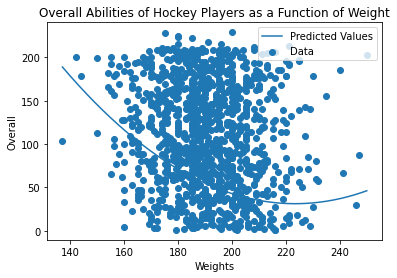

Out of sample rsquared is  -63.12153961246128


In [11]:
#now test the model out of sample using a secondary test data set
df_test=pd.read_csv('hockey_draftees_test.csv')

# Make the scatter plot 
plt.scatter(df_test.wt,df_test.overall, label="Data")
plt.xlabel("Weights")
plt.ylabel("Overall")
plt.title("Overall Abilities of Hockey Players as a Function of Weight")

# Generate and plot the predicted values

weights_new=np.linspace(min(df_test.wt),max(df_test.wt),len(df_test.wt))
X_pred=np.c_[weights_new,weights_new**2]
y_pred=model.predict(X_pred)
plt.plot(weights_new,y_pred, label="Predicted Values")
plt.legend()
plt.show()

# Now do the prediction for the test data and compute R2
#start by calculating the residual sum of squares
RSS=np.sum(np.square(np.subtract(df_test.wt,y_pred)))
#now calculate the total sum of squares
TSS=np.sum(np.square(np.subtract(df_test.wt,np.mean(df_test.wt))))
#now calculate the R^2 value
R2_oos=1-(RSS/TSS)

print('Out of sample rsquared is ', R2_oos)



Observation: The poor quality of this fit can be explained by the fact that the model was trained before being called in this section on the boot-strap samples in Q5, which consisted of data from hockey players who were drafted in 2005 only. There could be any correlation between the overall performance of hockey players, their weight, and the year in which they were drafted which would make fitting this out-of-sample data set with the model trained for players only drafted in 2005 inappropriate. The signifiantly low R2 value would suggest that this model is not a good fit for the data set, so we might be able to conclude that this difference in draft years could be the culprit.

In [12]:
#define a function which computes a 95% confidence interval for a given data set
def confidence_interval(data):
    estimated_mean=np.mean(data)
    # get the t-statistic
    n=len(data)
    t_val=t.ppf(1-0.05/2,df=n-1)
    # compute the standard error of the input data
    stdErr=data.std(ddof=1)/np.sqrt(data.size)
    #now compute the actual upper and lower bounds of the confidence interval
    upper=estimated_mean+t_val*stdErr
    lower=estimated_mean-t_val*stdErr
    bounds=np.array([lower,upper])

    # Note, np.std divides by n and not n-1
    # Force it to apply the correct formula by ussing ddof=1
    # Alternatively, you can use scipy.stats.sem to compute
    #The standard error
    
    return estimated_mean, bounds